In [1]:
pip install dash

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: C:\Users\Archana\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
# loading packages
# basic + dates
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from math import sqrt
from sklearn.metrics import mean_squared_error

In [3]:
# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
%matplotlib inline

In [4]:
# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
# importing data
transaction = pd.read_csv("Open Bank Transaction Data - Anonymized Original with Category.csv", parse_dates = True, index_col = 'Transaction Date')

In [7]:
transaction.head(5)

Transaction Number Transaction Type Transaction Description  \
Transaction Date                                                                
2022-07-25                         1               BP         SAVE THE CHANGE   
2022-07-25                         2              DEB      LIDL GB  NOTTINGHA   
2022-07-25                         3              DEB       NON-GBP PURCH FEE   
2022-07-25                         4              DEB       NON-GBP TRANS FEE   
2022-07-25                         5              DEB           TRAVELIUM LLC   

                  Debit Amount  Credit Amount  Balance   Category  \
Transaction Date                                                    
2022-07-25                3.11            NaN   541.43    Savings   
2022-07-25               15.02            NaN   544.54  Groceries   
2022-07-25                0.50            NaN   559.56     Others   
2022-07-25                0.37            NaN   560.06     Others   
2022-07-25               12.59            NaN   560.43        NaN   

                 Location City Location Country  
Transaction Date                                 
2022-07-25          Nottingham               UK  
2022-07-25          Nottingham               UK  
2022-07-25          Nottingham               UK  
2022-07-25          Nottingham               UK  
2022-07-25                 NaN              NaN

In [8]:
# Check if date has been defined as an index
transaction.index

DatetimeIndex(['2022-07-25', '2022-07-25', '2022-07-25', '2022-07-25',
               '2022-07-25', '2022-07-25', '2022-07-25', '2022-07-25',
               '2022-07-22', '2022-07-22',
               ...
               '2015-07-30', '2015-07-29', '2015-07-29', '2015-07-29',
               '2015-07-29', '2015-07-28', '2015-07-28', '2015-07-27',
               '2015-07-27', '2015-07-27'],
              dtype='datetime64[ns]', name='Transaction Date', length=6567, freq=None)

In [9]:
print("The number of rows: ",transaction.shape[0], "\n""The number of columns: ",transaction.shape[1])

The number of rows:  6567 
The number of columns:  9


In [10]:
#Extracting some additional features
#Creating separate columns for 'Year','Month','Day' and 'WeekofYear'
transaction['Year'] = transaction.index.year
transaction['Month'] = transaction.index.month
transaction['Day'] = transaction.index.day
transaction['WeekOfYear'] = transaction.index.isocalendar().week

In [11]:
## Plot ECDF: Empirical Cumulative Distribution Function
#ECDF - Adds up the number of observations that are there for a certain value.
cdf = ECDF(transaction['Balance'])
fig = px.line(x=cdf.x, y=cdf.y, labels={'x': 'Balance', 'y': 'ECDF'})
fig.update_layout(title="Empirical Cumulative Distribution Function (ECDF)")
fig.show()

Around 50 percent of the time the balance in the account is below 10,000

In [12]:
# Check for missing values
transaction.isnull().sum()

Transaction Number            0
Transaction Type             61
Transaction Description       0
Debit Amount                445
Credit Amount              6122
Balance                       0
Category                     24
Location City               672
Location Country            686
Year                          0
Month                         0
Day                           0
WeekOfYear                    0
dtype: int64

In [13]:
# null values in Credit Amount and Debit amount is replaced with zero
transaction["Debit Amount"] = transaction["Debit Amount"].fillna(0)

In [14]:
transaction["Credit Amount"] = transaction["Credit Amount"].fillna(0)

In [15]:
# Replacing Null values of Categorical variables with mode

In [16]:
mode_category = transaction['Category'].mode()[0]
mode_type = transaction['Transaction Type'].mode()[0]
mode_city = transaction['Location City'].mode()[0]
mode_country = transaction['Location Country'].mode()[0]


In [17]:
transaction['Transaction Type'] = transaction['Transaction Type'].fillna(mode_type)
transaction['Category'] = transaction['Category'].fillna(mode_category)
transaction['Location City'] = transaction['Location City'].fillna(mode_city)
transaction['Location Country'] = transaction['Location Country'].fillna(mode_country)

In [18]:
transaction.isnull().sum()

Transaction Number         0
Transaction Type           0
Transaction Description    0
Debit Amount               0
Credit Amount              0
Balance                    0
Category                   0
Location City              0
Location Country           0
Year                       0
Month                      0
Day                        0
WeekOfYear                 0
dtype: int64

In [19]:
transaction.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6567 entries, 2022-07-25 to 2015-07-27
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Transaction Number       6567 non-null   int64  
 1   Transaction Type         6567 non-null   object 
 2   Transaction Description  6567 non-null   object 
 3   Debit Amount             6567 non-null   float64
 4   Credit Amount            6567 non-null   float64
 5   Balance                  6567 non-null   float64
 6   Category                 6567 non-null   object 
 7   Location City            6567 non-null   object 
 8   Location Country         6567 non-null   object 
 9   Year                     6567 non-null   int64  
 10  Month                    6567 non-null   int64  
 11  Day                      6567 non-null   int64  
 12  WeekOfYear               6567 non-null   UInt32 
dtypes: UInt32(1), float64(3), int64(4), object(5)
memory usage: 

In [20]:
# group by date and get average Balance, and precent change
average_balance = transaction.groupby('Transaction Date')["Balance"].mean()
pct_change_balance = transaction.groupby('Transaction Date')["Balance"].sum().pct_change()
# plot average balance over time(year-month)
# plot precent change in balance over time(year-month)
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles=("Average Balance", "Balance Percent Change"))
fig.add_trace(go.Scatter(x=average_balance.index, y=average_balance.values, mode='lines+markers', name='Average Balance'), row=1, col=1)
fig.add_trace(go.Scatter(x=pct_change_balance.index, y=pct_change_balance.values, mode='lines+markers', name='Balance Percent Change', line=dict(color='green')), row=2, col=1)
fig.update_xaxes(title_text="Transaction Date")
fig.update_layout(title="Average Balance and Balance Percent Change Over Time")
fig.show()

In [21]:
## Plot average Balance for every Year
avg_balance_year = transaction.groupby('Year')['Balance'].mean().reset_index()
fig = px.bar(avg_balance_year, x='Year', y='Balance', labels={'x': 'Year', 'y': 'Average Balance'})
fig.update_layout(title="Average Balance for Every Year")
fig.show()
## Plot average Balance for every month
avg_balance_month = transaction.groupby('Month')['Balance'].mean().reset_index()
fig = px.bar(avg_balance_month, x='Month', y='Balance', labels={'x': 'Month', 'y': 'Average Balance'})
fig.update_layout(title="Average Balance for Every Month")
fig.show()
# Plot average balance in different countries
avg_balance_country = transaction.groupby('Location Country')['Balance'].mean().reset_index()
fig = px.bar(avg_balance_country, x='Location Country', y='Balance', labels={'x': 'Location Country', 'y': 'Average Balance'})
fig.update_layout(title="Average Balance in Different Countries")
fig.show()

In [22]:
# Heatmap of Correlation
corr_matrix = transaction.drop('Transaction Number', axis=1).corr()
fig = px.imshow(corr_matrix, color_continuous_scale='Viridis')
fig.update_layout(title="Correlation Heatmap")
fig.show()

In [23]:
# Time Series Plot
transaction_sort = transaction['Balance'].sort_index(ascending=True)
weekly_balance_sum = transaction_sort.resample('W').sum()
fig = px.line(x=weekly_balance_sum.index, y=weekly_balance_sum.values, labels={'x': 'Transaction Date', 'y': 'Balance'})
fig.update_layout(title="Weekly Sum of Balance")
fig.show()

Seasonality does exists in the data set. The balance had a peak in December, January, and March.

In [24]:
# Seasonal Decomposition
decomposition = seasonal_decompose(transaction_sort, model='additive', period=365)
fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter(x=decomposition.trend.index, y=decomposition.trend, mode='lines', name='Trend'), row=1, col=1)
fig.update_xaxes(title_text="Transaction Date")
fig.update_layout(title="Trend of Balance")
fig.show()

From 2018, Balance shows a continuous decline trend.

In [25]:
# ACF and PACF Plots
acf_values = sm.tsa.acf(transaction_sort, nlags=30)
pacf_values = sm.tsa.pacf(transaction_sort, nlags=30)

significant_lags = np.where(np.abs(acf_values) >= 1.96 / np.sqrt(len(transaction_sort)))[0]

fig = make_subplots(rows=2, cols=1, subplot_titles=("Autocorrelation Function (ACF)", "Partial Autocorrelation Function (PACF)"))
fig.add_trace(go.Scatter(x=np.arange(0, 31), y=acf_values, fill='tozeroy', name='ACF', fillcolor='rgba(0, 100, 80, 0.2)'), row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(0, 31), y=pacf_values, fill='tozeroy', name='PACF', fillcolor='rgba(0, 100, 200, 0.2)'), row=2, col=1)
fig.update_xaxes(title_text="Lags")
fig.update_yaxes(title_text="ACF Value", row=1, col=1)
fig.update_yaxes(title_text="PACF Value", row=2, col=1)
fig.update_layout(title="ACF and PACF Plots with Significant Area", showlegend=True)
fig.update_layout(shapes=[dict(type="rect", xref="x1", yref="paper", x0=significant_lags.min() - 0.5, x1=significant_lags.max() + 0.5, y0=0, y1=1, fillcolor="rgba(255, 0, 0, 0.1)", layer="below")])
fig.show()

In [26]:
# No particular seasonal component could be identified from the graph

In [27]:
train = transaction[transaction['Year'].isin([2016, 2017, 2018, 2019, 2020])]
test = transaction[transaction['Year'].isin([2021, 2022])]

In [28]:
train = train. sort_index(ascending=True)
test = test. sort_index(ascending=True)

In [29]:
train.head(5)

Transaction Number Transaction Type Transaction Description  \
Transaction Date                                                                
2016-01-02                      6077               BP         SAVE THE CHANGE   
2016-01-02                      6075               DD          TV LICENCE MBP   
2016-01-02                      6074               DD         GOOD ENERGY LTD   
2016-01-02                      6073               DD       DWR CYMRU W WATER   
2016-01-02                      6072               DD         GOOD ENERGY GAS   

                  Debit Amount  Credit Amount   Balance Category  \
Transaction Date                                                   
2016-01-02                0.85            0.0  12142.16  Savings   
2016-01-02               12.12            0.0  11830.04    Bills   
2016-01-02               13.00            0.0  11817.04    Bills   
2016-01-02               14.50            0.0  11802.54    Bills   
2016-01-02               43.00            0.0  11759.54    Bills   

                 Location City Location Country  Year  Month  Day  WeekOfYear  
Transaction Date                                                               
2016-01-02             Swansea               UK  2016      1    2          53  
2016-01-02             Swansea               UK  2016      1    2          53  
2016-01-02             Swansea               UK  2016      1    2          53  
2016-01-02             Swansea               UK  2016      1    2          53  
2016-01-02             Swansea               UK  2016      1    2          53

In [30]:
print(train.shape)
print(test.shape)

(4179, 13)
(1963, 13)


In [31]:
## Test for stationarity of the series - Dicky Fuller test

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window=7).mean()
    rolstd = timeseries.rolling(window=7).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput,'\n')

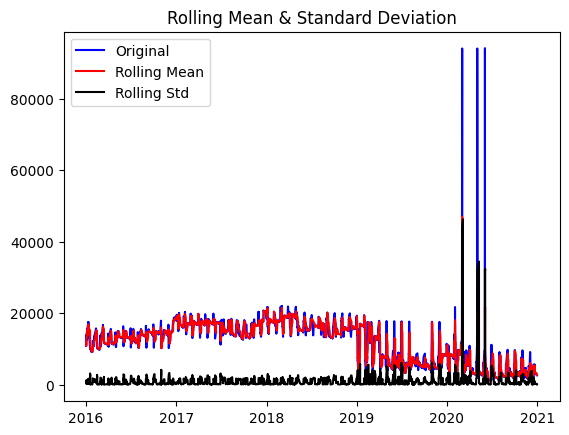

Results of Dickey-Fuller Test:
Test Statistic                   -4.566462
p-value                           0.000149
#Lags Used                       20.000000
Number of Observations Used    4158.000000
Critical Value (1%)              -3.431924
Critical Value (5%)              -2.862235
Critical Value (10%)             -2.567140
dtype: float64 



In [32]:
test_stationarity(train['Balance'])

In [33]:
## Series is stationary and hence no need for differentiation

In [34]:
import itertools
p = q = range(0, 3)
d= range(0,1)
pdq = list(itertools.product(p, d, q))
model_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Model...')
print('Model: {}{}'.format(pdq[1], model_pdq[1]))
print('Model: {}{}'.format(pdq[1], model_pdq[2]))
print('Model: {}{}'.format(pdq[2], model_pdq[3]))
print('Model: {}{}'.format(pdq[2], model_pdq[4]))

Examples of parameter combinations for Model...
Model: (0, 0, 1)(0, 0, 1, 7)
Model: (0, 0, 1)(0, 0, 2, 7)
Model: (0, 0, 2)(1, 0, 0, 7)
Model: (0, 0, 2)(1, 0, 1, 7)


In [35]:
# Creating an empty Dataframe with column names only
ARIMA_AIC = pd.DataFrame(columns=['param', 'AIC'])
print(ARIMA_AIC)

Empty DataFrame
Columns: [param, AIC]
Index: []


In [36]:
train['Balance']

Transaction Date
2016-01-02    12142.16
2016-01-02    11830.04
2016-01-02    11817.04
2016-01-02    11802.54
2016-01-02    11759.54
                ...   
2020-12-30     2646.53
2020-12-30     2631.20
2020-12-31     2630.53
2020-12-31     2611.89
2020-12-31     2596.04
Name: Balance, Length: 4179, dtype: float64

In [37]:
import statsmodels.api as sm

# ARIMA_AIC = pd.DataFrame(columns=['param', 'AIC'])

# for param in pdq:
#    ARIMA_model = sm.tsa.ARIMA(train['Balance'], order=param).fit()
#    print('ARIMA{} - AIC:{}'.format(param, ARIMA_model.aic))
#    ARIMA_AIC = ARIMA_AIC.append({'param': param, 'AIC': ARIMA_model.aic}, ignore_index=True)

In [38]:
# ARIMA_AIC.sort_values(by='AIC',ascending=True)

In [39]:
## ARIMA(2,0,2) has the lowest AIC
mod = sm.tsa.ARIMA(train['Balance'], order=(2,0,2))

results_Arima = mod.fit()

print(results_Arima.summary())

                               SARIMAX Results                                
Dep. Variable:                Balance   No. Observations:                 4179
Model:                 ARIMA(2, 0, 2)   Log Likelihood              -39521.622
Date:                Thu, 07 Sep 2023   AIC                          79055.245
Time:                        13:34:38   BIC                          79093.272
Sample:                             0   HQIC                         79068.694
                               - 4179                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.16e+04   2.08e-09   5.59e+12      0.000    1.16e+04    1.16e+04
ar.L1          1.7623      0.006    306.314      0.000       1.751       1.774
ar.L2         -0.7624      0.006   -134.855      0.0

In [40]:
test.Balance= test.Balance.astype(float)
final_hat_avg =test.copy()
pred = results_Arima.forecast(steps=1963)

In [41]:
# Convert forecast to a DataFrame
pred_df = pd.DataFrame(pred, columns=['predicted_mean'])
pred_df.reset_index(drop=True, inplace=True)
test1=test.reset_index(drop=True)
# Combine test and prediction DataFrames
combined_df = pd.concat([test1, pred_df], axis=1)

In [42]:
# Plotting forecast
fig = go.Figure()
fig.add_trace(go.Scatter(x=combined_df.index, y=combined_df['Balance'], mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=combined_df.index, y=combined_df['predicted_mean'], mode='lines', name='Predicted'))
fig.update_xaxes(title_text="Transaction Date")
fig.update_layout(title="Actual vs. Predicted Balance using ARIMA")
fig.show()

In [43]:
pred=pred.reset_index()

In [44]:
# pred

In [45]:
test=test.reset_index()

In [46]:
# test

In [47]:
from sklearn.metrics import mean_squared_error

pred.index = test.index

# Calculate the RMSE with matching indices
rmse = mean_squared_error(test['Balance'], pred['predicted_mean'], squared=False)
print(rmse)

4829.063315524146


In [48]:
resultsDf = pd.DataFrame({'RMSE': [rmse]}
                           ,index=['ARIMA(2,0,2)'])

resultsDf

RMSE
ARIMA(2,0,2)  4829.063316

SARIMA

In [49]:
SARIMA_AIC = pd.DataFrame(columns=['param','seasonal', 'AIC'])
print(SARIMA_AIC)

Empty DataFrame
Columns: [param, seasonal, AIC]
Index: []


In [50]:
SARIMA_AIC

Empty DataFrame
Columns: [param, seasonal, AIC]
Index: []

In [51]:
import statsmodels.api as sm

In [52]:
# for param in pdq:
#    for param_seasonal in model_pdq:
#        SARIMA_model = sm.tsa.statespace.SARIMAX(train['Balance'],
#                                            order=param,
#                                            seasonal_order=param_seasonal,
#                                            enforce_stationarity=False,
#                                            enforce_invertibility=False)
#
#        results_SARIMA = SARIMA_model.fit()
#        print('SARIMA{}x{}7 - AIC:{}'.format(param, param_seasonal, results_SARIMA.aic))
#        SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


In [53]:
# SARIMA_AIC.sort_values(by=['AIC']).head()

In [54]:
import statsmodels.api as sm

## SARIMA (2, 0, 2)	(0, 0, 2, 7)
mod = sm.tsa.statespace.SARIMAX(train['Balance'],
                                order=(2,0,2),
                                seasonal_order=(0, 0, 2, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_SARIMA = mod.fit()
print(results_SARIMA.summary())

                                     SARIMAX Results                                     
Dep. Variable:                           Balance   No. Observations:                 4179
Model:             SARIMAX(2, 0, 2)x(0, 0, 2, 7)   Log Likelihood              -39369.658
Date:                           Thu, 07 Sep 2023   AIC                          78753.315
Time:                                   13:34:45   BIC                          78797.651
Sample:                                        0   HQIC                         78768.999
                                          - 4179                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7339      0.006    296.647      0.000       1.722       1.745
ar.L2         -0.7339      0.006   -124.953

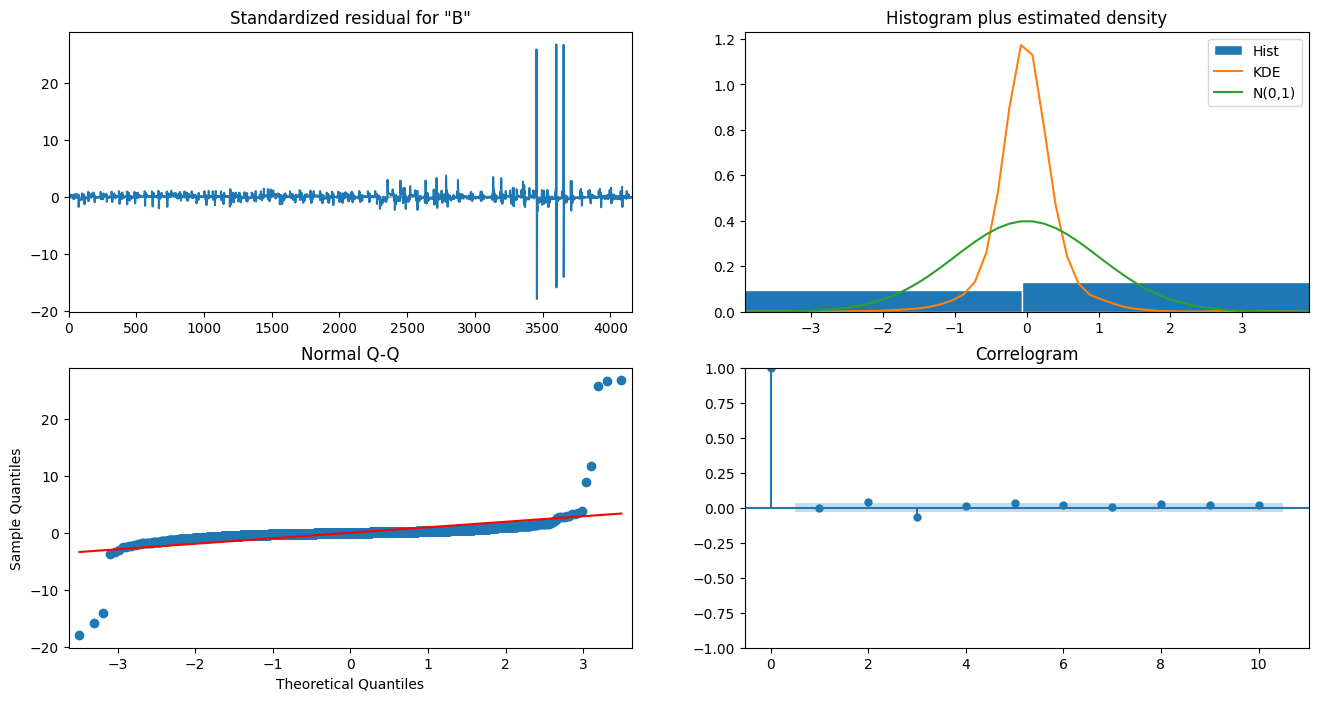

In [55]:
results_SARIMA.plot_diagnostics(figsize=(16, 8))
plt.show()

In [56]:
test.head()

Transaction Date  Transaction Number Transaction Type  \
0       2021-01-02                1889              DEB   
1       2021-01-02                1887              DEB   
2       2021-01-02                1886               BP   
3       2021-01-02                1885               SO   
4       2021-01-02                1884               SO   

  Transaction Description  Debit Amount  Credit Amount  Balance  \
0      LIDL GB  NOTTINGHA          4.80            0.0  2920.71   
1      ORIENTAL MART HYDR         18.71            0.0  2891.95   
2         SAVE THE CHANGE          2.44            0.0  2889.51   
3        ESAVINGS ACCOUNT        300.00            0.0  2589.51   
4                  Q WANG          0.00         1000.0  3589.51   

               Category Location City Location Country  Year  Month  Day  \
0             Groceries    Nottingham               UK  2021      1    2   
1             Groceries    Nottingham               UK  2021      1    2   
2               Savings    Nottingham               UK  2021      1    2   
3               Savings    Nottingham               UK  2021      1    2   
4  Supplementary Income    Nottingham               UK  2021      1    2   

   WeekOfYear  
0          53  
1          53  
2          53  
3          53  
4          53

In [57]:
test.Balance= test.Balance.astype(float)
final_hat_avg =test.copy()
pred = results_SARIMA.get_forecast(steps=1963)
pred.predicted_mean

4179    2865.294594
4180    3008.614553
4181    3110.560673
4182    3187.230588
4183    3243.443310
           ...     
6137    1993.915880
6138    1993.365116
6139    1992.814503
6140    1992.264043
6141    1991.713735
Name: predicted_mean, Length: 1963, dtype: float64

In [58]:
pred

In [59]:
# Convert forecast to a DataFrame
pred_df = pd.DataFrame(pred.predicted_mean, columns=['predicted_mean'])
pred_df.reset_index(drop=True, inplace=True)
# Combine test and prediction DataFrames
combined_df = pd.concat([test, pred_df], axis=1)

In [60]:
# Plotting the line chart
# Plotting forecast
fig = go.Figure()
fig.add_trace(go.Scatter(x=combined_df.index, y=combined_df['Balance'], mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=combined_df.index, y=combined_df['predicted_mean'], mode='lines', name='Predicted'))
fig.update_xaxes(title_text="Transaction Date")
fig.update_layout(title="Actual vs. Predicted Balance using SARIMA")
fig.show()

In [61]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(test.Balance ,pred.predicted_mean))
print(rmse)

1544.299884425539


In [62]:
temp_resultsDf = pd.DataFrame({'RMSE': [rmse]}
                           ,index=['SARIMA(2, 0, 2)(0, 0, 2, 7)'])

resultsDf = pd.concat([resultsDf, temp_resultsDf])
resultsDf

RMSE
ARIMA(2,0,2)                 4829.063316
SARIMA(2, 0, 2)(0, 0, 2, 7)  1544.299884

SARIMAX Models (with exogeneous variables)

In [63]:
train.head(5)

Transaction Number Transaction Type Transaction Description  \
Transaction Date                                                                
2016-01-02                      6077               BP         SAVE THE CHANGE   
2016-01-02                      6075               DD          TV LICENCE MBP   
2016-01-02                      6074               DD         GOOD ENERGY LTD   
2016-01-02                      6073               DD       DWR CYMRU W WATER   
2016-01-02                      6072               DD         GOOD ENERGY GAS   

                  Debit Amount  Credit Amount   Balance Category  \
Transaction Date                                                   
2016-01-02                0.85            0.0  12142.16  Savings   
2016-01-02               12.12            0.0  11830.04    Bills   
2016-01-02               13.00            0.0  11817.04    Bills   
2016-01-02               14.50            0.0  11802.54    Bills   
2016-01-02               43.00            0.0  11759.54    Bills   

                 Location City Location Country  Year  Month  Day  WeekOfYear  
Transaction Date                                                               
2016-01-02             Swansea               UK  2016      1    2          53  
2016-01-02             Swansea               UK  2016      1    2          53  
2016-01-02             Swansea               UK  2016      1    2          53  
2016-01-02             Swansea               UK  2016      1    2          53  
2016-01-02             Swansea               UK  2016      1    2          53

In [64]:
ex_train=train[['Transaction Type','Category','Location City','Location Country']]
ex_test=test[['Transaction Type','Category','Location City','Location Country']]

In [65]:
ex_train.head(5)

Transaction Type Category Location City Location Country
Transaction Date                                                         
2016-01-02                     BP  Savings       Swansea               UK
2016-01-02                     DD    Bills       Swansea               UK
2016-01-02                     DD    Bills       Swansea               UK
2016-01-02                     DD    Bills       Swansea               UK
2016-01-02                     DD    Bills       Swansea               UK

In [66]:
# Convert categorical columns to numerical columns using one-hot encoding
ex_train = pd.get_dummies(ex_train, columns=['Transaction Type', 'Category', 'Location City', 'Location Country'])
ex_test = pd.get_dummies(ex_test, columns=['Transaction Type', 'Category', 'Location City', 'Location Country'])

In [67]:
ex_train.head(5)

Transaction Type_BGC  Transaction Type_BP  \
Transaction Date                                              
2016-01-02                           0                    1   
2016-01-02                           0                    0   
2016-01-02                           0                    0   
2016-01-02                           0                    0   
2016-01-02                           0                    0   

                  Transaction Type_CHQ  Transaction Type_CPT  \
Transaction Date                                               
2016-01-02                           0                     0   
2016-01-02                           0                     0   
2016-01-02                           0                     0   
2016-01-02                           0                     0   
2016-01-02                           0                     0   

                  Transaction Type_DD  Transaction Type_DEB  \
Transaction Date                                              
2016-01-02                          0                     0   
2016-01-02                          1                     0   
2016-01-02                          1                     0   
2016-01-02                          1                     0   
2016-01-02                          1                     0   

                  Transaction Type_DEP  Transaction Type_FEE  \
Transaction Date                                               
2016-01-02                           0                     0   
2016-01-02                           0                     0   
2016-01-02                           0                     0   
2016-01-02                           0                     0   
2016-01-02                           0                     0   

                  Transaction Type_FPI  Transaction Type_FPO  ...  \
Transaction Date                                              ...   
2016-01-02                           0                     0  ...   
2016-01-02                           0                     0  ...   
2016-01-02                           0                     0  ...   
2016-01-02                           0                     0  ...   
2016-01-02                           0                     0  ...   

                  Location Country_Hungary  Location Country_Italy  \
Transaction Date                                                     
2016-01-02                               0                       0   
2016-01-02                               0                       0   
2016-01-02                               0                       0   
2016-01-02                               0                       0   
2016-01-02                               0                       0   

                  Location Country_Moldova  Location Country_Morocco  \
Transaction Date                                                       
2016-01-02                               0                         0   
2016-01-02                               0                         0   
2016-01-02                               0                         0   
2016-01-02                               0                         0   
2016-01-02                               0                         0   

                  Location Country_Netherlands  Location Country_Portugal  \
Transaction Date                                                            
2016-01-02                                   0                          0   
2016-01-02                                   0                          0   
2016-01-02                                   0                          0   
2016-01-02                                   0                          0   
2016-01-02                                   0                          0   

                  Location Country_Prague  Location Country_Spain  \
Transaction Date                                                    
2016-01-02                              0                       0   
2016-01-0

In [68]:
missing_columns = [col for col in ex_train.columns if col not in ex_test.columns]
missing_columns

['Transaction Type_CHQ',
 'Transaction Type_FEE',
 'Category_Account transfer',
 'Category_Groceries ',
 'Category_Insurance',
 'Category_Mortgage',
 'Category_Purchase of uk.eg.org',
 'Category_Rent',
 'Location City_Aarhus',
 'Location City_Almería',
 'Location City_Amsterdam',
 'Location City_Baltimore',
 'Location City_Berlin',
 'Location City_Boston',
 'Location City_Bristol',
 'Location City_Brno',
 'Location City_Budapest',
 'Location City_Cambridge',
 'Location City_Cardiff',
 'Location City_Casablanca',
 'Location City_Genova',
 'Location City_Houston',
 'Location City_Huston',
 'Location City_Illes Balears',
 'Location City_Lampeter',
 'Location City_Lisbon',
 'Location City_Madrid',
 'Location City_Malia',
 'Location City_Manchester',
 'Location City_Middleton',
 'Location City_New Brighton',
 'Location City_Oakham',
 'Location City_Paris',
 'Location City_Phoenix',
 'Location City_Porto',
 'Location City_Prague',
 'Location City_Santa Cruz de Tenerife',
 'Location City_Setu

In [69]:
# Add missing columns to ex_test with values of 0
for col in missing_columns:
    ex_test[col] = 0

In [70]:
# Identify columns to delete from ex_test
columns_to_delete = [col for col in ex_test.columns if col not in ex_train.columns]

# Drop the identified columns from ex_test
ex_test.drop(columns=columns_to_delete, inplace=True)

In [71]:
ex_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4179 entries, 2016-01-02 to 2020-12-31
Data columns (total 98 columns):
 #   Column                                Non-Null Count  Dtype
---  ------                                --------------  -----
 0   Transaction Type_BGC                  4179 non-null   uint8
 1   Transaction Type_BP                   4179 non-null   uint8
 2   Transaction Type_CHQ                  4179 non-null   uint8
 3   Transaction Type_CPT                  4179 non-null   uint8
 4   Transaction Type_DD                   4179 non-null   uint8
 5   Transaction Type_DEB                  4179 non-null   uint8
 6   Transaction Type_DEP                  4179 non-null   uint8
 7   Transaction Type_FEE                  4179 non-null   uint8
 8   Transaction Type_FPI                  4179 non-null   uint8
 9   Transaction Type_FPO                  4179 non-null   uint8
 10  Transaction Type_PAY                  4179 non-null   uint8
 11  Transaction Type_SO      

In [72]:
SARIMAX_AIC = pd.DataFrame(columns=['param','seasonal', 'AIC'])
print(SARIMAX_AIC)

Empty DataFrame
Columns: [param, seasonal, AIC]
Index: []


In [73]:
## SARIMAX with exogenous variable

# for param in pdq:
#    for param_seasonal in model_pdq:
#        mod = sm.tsa.statespace.SARIMAX(train['Balance'],exog=ex_train,
#                                            order=param,
#                                            seasonal_order=param_seasonal,
#                                            enforce_stationarity=False,
#                                            enforce_invertibility=False)
#
#        results_SARIMAX = mod.fit()
#        print('SARIMA{}{} - AIC:{}'.format(param, param_seasonal, results_SARIMAX.aic))
#        SARIMAX_AIC = SARIMAX_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMAX.aic}, ignore_index=True)

In [74]:
# SARIMA(2, 0, 2)(0, 0, 2, 7)
mod = sm.tsa.statespace.SARIMAX(train['Balance'],exog=ex_train,
                                order=(2,0,2),
                                seasonal_order=(0, 0, 2, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                           Balance   No. Observations:                 4179
Model:             SARIMAX(2, 0, 2)x(0, 0, 2, 7)   Log Likelihood              -40044.775
Date:                           Thu, 07 Sep 2023   AIC                          80299.550
Time:                                   13:36:55   BIC                          80964.594
Sample:                                        0   HQIC                         80534.816
                                          - 4179                                         
Covariance Type:                             opg                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Transaction Type_BGC                  2275.6223    923.559      2.464 

In [75]:
pred = results.get_forecast(steps=1963,exog=ex_test)
pred.predicted_mean

4179    18244.675901
4180    18127.454318
4181    17955.471493
4182    17049.204884
4183    14306.047316
            ...     
6137    19872.910188
6138    24415.698480
6139    22117.000498
6140    24416.019071
6141    19873.551370
Name: predicted_mean, Length: 1963, dtype: float64

In [76]:
# Convert forecast to a DataFrame
pred_df = pd.DataFrame(pred.predicted_mean, columns=['predicted_mean'])
pred_df.reset_index(drop=True, inplace=True)
# Combine test and prediction DataFrames
combined_df = pd.concat([test, pred_df], axis=1)

In [77]:
# Plotting forecast
fig = go.Figure()
fig.add_trace(go.Scatter(x=combined_df.index, y=combined_df['Balance'], mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=combined_df.index, y=combined_df['predicted_mean'], mode='lines', name='Predicted'))
fig.update_xaxes(title_text="Transaction Date")
fig.update_layout(title="Actual vs. Predicted Balance using SARIMA (with exogeneous variables)")
fig.show()

In [78]:
rmse_SARIMAX = sqrt(mean_squared_error(test.Balance ,pred.predicted_mean))
print(rmse_SARIMAX)

19034.101044316092


In [79]:
temp_resultsDf = pd.DataFrame({'RMSE': [rmse_SARIMAX]}
                           ,index=['SARIMAX(2, 0, 2)(0, 0, 2, 7)'])

resultsDf = pd.concat([resultsDf, temp_resultsDf])
resultsDf

RMSE
ARIMA(2,0,2)                   4829.063316
SARIMA(2, 0, 2)(0, 0, 2, 7)    1544.299884
SARIMAX(2, 0, 2)(0, 0, 2, 7)  19034.101044

In [80]:
resultsDf

RMSE
ARIMA(2,0,2)                   4829.063316
SARIMA(2, 0, 2)(0, 0, 2, 7)    1544.299884
SARIMAX(2, 0, 2)(0, 0, 2, 7)  19034.101044

In [81]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output

In [82]:
pip install dash-bootstrap-components

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: C:\Users\Archana\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [83]:
pip install dash_daq

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: C:\Users\Archana\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [84]:
# Additional Dash components
import dash_bootstrap_components as dbc
import dash_daq as daq
from dash.dependencies import Input, Output
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [85]:
# Create the Dash app
app = dash.Dash(__name__)

# Define the layout of the dashboard
app.layout = html.Div([
    html.H1("Transaction Data Dashboard", style={'textAlign': 'center'}),

    # Key Metrics and Summaries
    html.Div([
        html.Div([
            html.H3("Key Metrics"),
            html.Div(id='key-metrics')
        ], className='metric-card'),

        html.Div([
            html.H3("Model Comparison"),
            dcc.Graph(id='model-comparison')
        ], className='metric-card')
    ], className='summary-section'),

    # Interactive Visualizations
    html.Div([
        html.Div([
            dcc.Dropdown(
                id='year-dropdown',
                options=[
                    {'label': str(year), 'value': year} for year in transaction['Year'].unique()
                ],
                value=transaction['Year'].min(),
                multi=False,
                clearable=False
            ),
            dcc.Graph(id='line-chart')
        ], className='interactive-plot'),

        html.Div([
            dcc.RangeSlider(
                id='date-slider',
                marks={i: str(i) for i in range(1, 13)},
                min=1,
                max=12,
                step=1,
                value=[1, 12]
            ),
            dcc.Graph(id='forecast-plot')
        ], className='interactive-plot')
    ], className='zoom-filter'),

    # Details on Demand
    html.Div([
        html.H3("Model Details"),
        dcc.Graph(id='residual-analysis')
    ], className='details-section'),

    # original transaction data graphs
    dcc.Graph(id='trend-balance-plot'),
    dcc.Graph(id='ecdf-plot'),
    dcc.Graph(id='average-balance-plot'),
    dcc.Graph(id='average-balance-year-plot'),
    dcc.Graph(id='average-balance-over-time'),
    dcc.Graph(id='average-balance-over-country'),
    dcc.Graph(id='average-weekly-balance'),
    dcc.Graph(id='correlation'),
    dcc.Graph(id='transaction-hierarchy'),
    dcc.Graph(id='category-debit-amount'),
    dcc.Graph(id='average-balance-heatmap')
])

# Callbacks to update the dashboard components

# Callback to update key metrics (RMSE) and model comparison chart
@app.callback(
    [Output('key-metrics', 'children'),
     Output('model-comparison', 'figure')],
    [Input('year-dropdown', 'value')]
)
def update_metrics(selected_year):
    # Calculate RMSE for different models (ARIMA, SARIMA, SARIMAX)
    rmse_arima = calculate_rmse(selected_year, model_order=(2, 0, 2))
    rmse_sarima = calculate_rmse_sarima(selected_year, model_order=(2, 0, 2), seasonal_order=(0, 0, 2, 7))
    rmse_sarimax = calculate_rmse_sarimax(selected_year, model_order=(2, 0, 2), seasonal_order=(0, 0, 2, 7))

    # Create a model comparison chart
    models = ['ARIMA', 'SARIMA', 'SARIMAX']
    rmse_values = [rmse_arima, rmse_sarima, rmse_sarimax]

    fig = px.bar(x=models, y=rmse_values, labels={'x': 'Model', 'y': 'RMSE'}, title="Model Comparison")

    return [
        html.Div([
            html.P(f"RMSE (ARIMA): {rmse_arima:.2f}"),
            html.P(f"RMSE (SARIMA): {rmse_sarima:.2f}"),
            html.P(f"RMSE (SARIMAX): {rmse_sarimax:.2f}")
        ]),
        fig
    ]

# Callback to update the line chart based on the selected year
@app.callback(
    Output('line-chart', 'figure'),
    [Input('year-dropdown', 'value')]
)
def update_line_chart(selected_year):
    # Filter data for the selected year
    filtered_data = transaction[transaction['Year'] == selected_year]
    filtered_data = filtered_data.sort_index()

    # Calculate predictions for all three models
    predicted_arima = predict_arima(selected_year)
    predicted_arima = predicted_arima.sort_index()
    predicted_sarima = predict_sarima(selected_year)
    predicted_sarima = predicted_sarima.sort_index()
    predicted_sarimax = predict_sarimax(selected_year)
    predicted_sarimax = predicted_sarimax.sort_index()

    # Create a line chart for actual and predicted values
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=filtered_data.index, y=filtered_data['Balance'], mode='lines', name='Actual'))
    fig.add_trace(go.Scatter(x=filtered_data.index, y=predicted_arima, mode='lines', name='ARIMA Predicted'))
    fig.add_trace(go.Scatter(x=filtered_data.index, y=predicted_sarima, mode='lines', name='SARIMA Predicted'))
    fig.add_trace(go.Scatter(x=filtered_data.index, y=predicted_sarimax, mode='lines', name='SARIMAX Predicted'))

    fig.update_layout(title=f"Actual vs. Predicted Balance for Year {selected_year}", xaxis_title="Transaction Date", yaxis_title="Balance")

    return fig

# Callback to update the forecast plot based on the selected date range
@app.callback(
    Output('forecast-plot', 'figure'),
    [Input('year-dropdown', 'value'),
     Input('date-slider', 'value')]
)
def update_forecast_plot(selected_year, date_range):
    # Filter data for the selected year
    filtered_data = transaction[transaction['Year'] == selected_year]

    # Calculate forecasts for all three models
    forecasts_arima = predict_arima(selected_year)
    forecasts_sarima = predict_sarima(selected_year)
    forecasts_sarimax = predict_sarimax(selected_year)

    # Create a plot with shaded regions for forecasts
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=filtered_data.index, y=filtered_data['Balance'], mode='lines', name='Actual'))
    fig.add_trace(go.Scatter(x=forecasts_arima.index, y=forecasts_arima, mode='lines', name='ARIMA Forecast'))
    fig.add_trace(go.Scatter(x=forecasts_sarima.index, y=forecasts_sarima, mode='lines', name='SARIMA Forecast'))
    fig.add_trace(go.Scatter(x=forecasts_sarimax.index, y=forecasts_sarimax, mode='lines', name='SARIMAX Forecast'))

    fig.update_layout(title=f"Forecasted Balance for Year {selected_year}", xaxis_title="Transaction Date", yaxis_title="Balance")

    # Customize the x-axis to show only the month
    fig.update_xaxes(
        type='category',  # Use category type for x-axis
        tickmode='array',  # Use an array of ticks
        tickvals=filtered_data.index,  # Set tick values to match the data index
        ticktext=[date.strftime('%b') for date in filtered_data.index]  # Format tick text as month
    )

    # Add shaded regions for forecasts
    for i in range(len(forecasts_arima)):
        fig.add_shape(type="rect", x0=forecasts_arima.index[i], x1=forecasts_arima.index[i], y0=0, y1=1,
                      xref="x", yref="paper", fillcolor="rgba(0, 100, 80, 0.2)", opacity=0.3)
    for i in range(len(forecasts_sarima)):
        fig.add_shape(type="rect", x0=forecasts_sarima.index[i], x1=forecasts_sarima.index[i], y0=0, y1=1,
                      xref="x", yref="paper", fillcolor="rgba(0, 100, 80, 0.2)", opacity=0.3)
    for i in range(len(forecasts_sarimax)):
        fig.add_shape(type="rect", x0=forecasts_sarimax.index[i], x1=forecasts_sarimax.index[i], y0=0, y1=1,
                      xref="x", yref="paper", fillcolor="rgba(0, 100, 80, 0.2)", opacity=0.3)

    return fig

# Callback to update residual analysis and feature importance plots
@app.callback(
    Output('residual-analysis', 'figure'),
    Input('year-dropdown', 'value')
)
def update_residual_and_feature_plots(selected_year):
    # Filter data for the selected year
    filtered_data = transaction[transaction['Year'] == selected_year]

    # Calculate residuals for ARIMA
    residuals_arima = calculate_residuals_arima(selected_year)
    # Calculate residuals for SARIMA
    residuals_sarima = calculate_residuals_sarima(selected_year)
    # Calculate residuals for SARIMAX
    residuals_sarimax = calculate_residuals_sarimax(selected_year)

    # Create a residual analysis histogram
    fig_residuals = go.Figure()
    fig_residuals.add_trace(go.Histogram(x=residuals_arima, nbinsx=20, name='ARIMA Residuals'))
    fig_residuals.add_trace(go.Histogram(x=residuals_sarima, nbinsx=20, name='SARIMA Residuals'))
    fig_residuals.add_trace(go.Histogram(x=residuals_sarimax, nbinsx=20, name='SARIMAX Residuals'))
    fig_residuals.update_layout(title=f"Residual Analysis for Year {selected_year}", xaxis_title="Residuals", yaxis_title="Frequency")
    return fig_residuals

# Callbacks for your original transaction data graphs

@app.callback(
    Output('trend-balance-plot', 'figure'),
    [Input('year-dropdown', 'value')]
)
def update_trend_balance_plot(selected_year):
    # Seasonal Decomposition
    filtered_data = transaction[transaction['Year'] == selected_year]
    transaction_sort = filtered_data['Balance'].sort_index(ascending=True)
    decomposition = seasonal_decompose(transaction_sort, model='additive', period=365)
    fig = make_subplots(rows=1, cols=1)
    fig.add_trace(go.Scatter(x=decomposition.trend.index, y=decomposition.trend, mode='lines', name='Trend'), row=1, col=1)
    fig.update_xaxes(title_text="Transaction Date")
    fig.update_layout(title="Trend of Balance")
    return fig

@app.callback(
    Output('ecdf-plot', 'figure'),
    [Input('year-dropdown', 'value')]
)
def update_ecdf_plot(selected_year):
    # Create and return the ECDF plot figure for the selected year
    filtered_data = transaction[transaction['Year'] == selected_year]
    ecdf = ECDF(filtered_data['Balance'])
    fig = go.Figure(data=[go.Scatter(x=ecdf.x, y=ecdf.y, mode='lines', name='ECDF')])
    fig.update_layout(title=f"ECDF for Year {selected_year}", xaxis_title="Balance", yaxis_title="ECDF")
    return fig

@app.callback(
    Output('average-balance-plot', 'figure'),
    [Input('year-dropdown', 'value')]
)
def update_average_balance_plot(selected_year):
    # Create and return the average balance plot figure
    filtered_data = transaction[transaction['Year'] == selected_year]
    avg_balance = filtered_data.groupby('Month')['Balance'].mean().reset_index()
    fig = px.bar(avg_balance, x='Month', y='Balance', labels={'x': 'Month', 'y': 'Average Balance'})
    fig.update_layout(title=f"Average Balance for Year {selected_year}")
    return fig

@app.callback(
    Output('average-balance-year-plot', 'figure'),
    [Input('year-dropdown', 'value')]
)
def update_average_balance_year_plot(selected_year):
    # Create and return the average balance by year plot figure
    avg_balance_year = transaction.groupby('Year')['Balance'].mean().reset_index()
    fig = px.bar(avg_balance_year, x='Year', y='Balance', labels={'x': 'Year', 'y': 'Average Balance'})
    fig.update_layout(title="Average Balance for Every Year")
    return fig

@app.callback(
    Output('average-balance-over-time', 'figure'),
    [Input('year-dropdown', 'value')]
)
def update_average_balance_over_time(selected_year):
    # Create and return the average balance by year plot figure
    filtered_data = transaction[transaction['Year'] == selected_year]
    average_balance = filtered_data.groupby('Transaction Date')["Balance"].mean()
    pct_change_balance = filtered_data.groupby('Transaction Date')["Balance"].sum().pct_change()
    # plot average balance over time(year-month)
    # plot precent change in balance over time(year-month)
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles=("Average Balance", "Balance Percent Change"))
    fig.add_trace(go.Scatter(x=average_balance.index, y=average_balance.values, mode='lines+markers', name='Average Balance'), row=1, col=1)
    fig.add_trace(go.Scatter(x=pct_change_balance.index, y=pct_change_balance.values, mode='lines+markers', name='Balance Percent Change', line=dict(color='green')), row=2, col=1)
    fig.update_xaxes(title_text="Transaction Date")
    fig.update_layout(title="Average Balance and Balance Percent Change Over Time")
    return fig

@app.callback(
    Output('average-balance-over-country', 'figure'),
    [Input('year-dropdown', 'value')]
)
def update_average_balance_over_country(selected_year):
    # Plot average balance in different countries
    filtered_data = transaction[transaction['Year'] == selected_year]
    avg_balance_country = filtered_data.groupby('Location Country')['Balance'].mean().reset_index()
    fig = px.bar(avg_balance_country, x='Location Country', y='Balance', labels={'x': 'Location Country', 'y': 'Average Balance'})
    fig.update_layout(title="Average Balance in Different Countries")
    return fig

@app.callback(
    Output('correlation', 'figure'),
    [Input('year-dropdown', 'value')]
)
def update_correlation(selected_year):
    # Heatmap of Correlation
    filtered_data = transaction[transaction['Year'] == selected_year]
    corr_matrix = filtered_data.drop('Year', axis=1)
    corr_matrix = corr_matrix.drop('Transaction Number', axis=1).corr()
    fig = px.imshow(corr_matrix, color_continuous_scale='Viridis')
    fig.update_layout(title="Correlation Heatmap")
    return fig


@app.callback(
    Output('transaction-hierarchy', 'figure'),
    [Input('year-dropdown', 'value')]
)
def update_transaction_hierarchy(selected_year):
    # Define category grouping (you can customize this based on your needs)
    category_groups = {
        'Groceries': 'Living Expenses',
        'Entertainment': 'Leisure',
        'Travel': 'Leisure',
        # Add more category groupings as needed
    }
    df = transaction[transaction['Year'] == selected_year]

    # Create a new column for the grouped categories
    df['Category Group'] = df['Category'].map(category_groups).fillna(df['Category'])

    # Create a hierarchical category for the sunburst chart
    df['Hierarchy'] = df['Transaction Type'] + ' - ' + df['Category Group'] + ' - ' + df['Transaction Description']

    # Filter the data based on selected category groups
    selected_category_groups = ['Living Expenses', 'Leisure']
    filtered_df = df[df['Category Group'].isin(selected_category_groups)]

    # Create the sunburst chart
    sunburst_fig = go.Figure(go.Sunburst(
        labels=filtered_df['Hierarchy'],
        parents=[''] * len(filtered_df),
        marker=dict(
            colors=filtered_df['Category Group'].astype('category').cat.codes,  # Assign colors based on the Category Group
            colorscale='Viridis',  # Use the Viridis color scale
            showscale=True,  # Show color scale legend
            colorbar=dict(title='Category Group'),  # Add a color bar legend
        ),
        customdata=filtered_df['Category Group'],  # Add custom data for legend grouping
        hovertemplate='<b>%{label}</b><br>Category Group: %{customdata}',
        name='legend',  # Name for the legend
    ))

    sunburst_fig.update_layout(
        title='Transaction Hierarchy Sunburst (Filtered)',
        margin=dict(l=0, r=0, b=0, t=40),  # Adjust the margin for better visibility
        sunburstcolorway=["#636efa", "#ef553b", "#00cc96", "#ab63fa", "#19d3f3", "#ffa15a", "#ff6692", "#b6e880"],
        extendsunburstcolors=True,
    )

    sunburst_fig.update_traces(
        textinfo='label+percent entry',
        insidetextorientation='radial',  # Display text radially
    )

    return sunburst_fig



@app.callback(
    Output('category-debit-amount', 'figure'),
    [Input('year-dropdown', 'value')]
)
def update_category_debit_amount(selected_year):

    df = transaction[transaction['Year'] == selected_year]

    # Custom color scale with vivid colors
    color_scale = px.colors.qualitative.Set1

    # Grouped bar chart
    fig = px.bar(df, x='Category', y='Debit Amount', color='Transaction Type',
                 title='Debit Amount by Transaction Type and Category',
                 labels={'Debit Amount': 'Debit Amount'},
                 category_orders={'Category': ['Living Expenses', 'Leisure']},
                 color_discrete_sequence=color_scale)

    # Customize the layout
    fig.update_layout(
        xaxis_title='Category',
        yaxis_title='Debit Amount',
        legend_title='Transaction Type',
        barmode='group',  # Grouped bar chart
    )

    return fig




@app.callback(
    Output('average-balance-heatmap', 'figure'),
    [Input('year-dropdown', 'value')]
)
def update_average_balance_heatmap(selected_year):
    df = transaction[transaction['Year'] == selected_year]
    # Heatmap
    heatmap_fig = px.imshow(df.groupby(['Transaction Type', 'Category'])['Balance'].mean().unstack(fill_value=0),
                            labels=dict(x='Category', y='Transaction Type', color='Balance'),
                            title='Average Balance by Transaction Type and Category')
    heatmap_trace = go.Heatmap(z=heatmap_fig.data[0]['z'], x=heatmap_fig.data[0]['x'], y=heatmap_fig.data[0]['y'], colorscale=heatmap_fig.data[0]['colorscale'])
    return heatmap_fig





@app.callback(
    Output('average-weekly-balance', 'figure'),
    [Input('year-dropdown', 'value')]
)
def update_average_weekly_balance(selected_year):
    # Time Series Plot
    filtered_data = transaction[transaction['Year'] == selected_year]
    transaction_sort = filtered_data['Balance'].sort_index(ascending=True)
    weekly_balance_sum = transaction_sort.resample('W').sum()
    fig = px.line(x=weekly_balance_sum.index, y=weekly_balance_sum.values, labels={'x': 'Transaction Date', 'y': 'Balance'})
    fig.update_layout(title="Weekly Sum of Balance")
    return fig



def calculate_rmse(selected_year, model_order):
    # Filter the dataset for the selected year
    selected_data = transaction[transaction['Year'] == selected_year]
    model = sm.tsa.ARIMA(selected_data['Balance'], order=model_order)
    results = model.fit()
    predicted_values = results.forecast(steps=len(transaction[transaction['Year'] == selected_year]))
    # Calculate RMSE
    rmse = sqrt(mean_squared_error(selected_data['Balance'], predicted_values))
    return rmse

def calculate_rmse_sarima(selected_year, model_order, seasonal_order):
    # Filter the dataset for the selected year
    selected_data = transaction[transaction['Year'] == selected_year]
    model = sm.tsa.statespace.SARIMAX(selected_data['Balance'], order=model_order, seasonal_order=seasonal_order,enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit()
    predicted_values = results.forecast(steps=len(transaction[transaction['Year'] == selected_year]))
    # Calculate RMSE
    rmse = sqrt(mean_squared_error(selected_data['Balance'], predicted_values))
    return rmse

def calculate_rmse_sarimax(selected_year, model_order, seasonal_order):
    # Filter the dataset for the selected year
    selected_data = transaction[transaction['Year'] == selected_year]
    ex_train=selected_data[['Transaction Type','Category','Location City','Location Country']]
    ex_train = pd.get_dummies(ex_train, columns=['Transaction Type', 'Category', 'Location City', 'Location Country'])
    model = sm.tsa.statespace.SARIMAX(selected_data['Balance'], exog=ex_train, order=model_order, seasonal_order=seasonal_order,enforce_stationarity=False,enforce_invertibility=False)
    results = model.fit()
    predicted_values = results.forecast(steps=len(transaction[transaction['Year'] == selected_year]), exog=ex_train)
    # Calculate RMSE
    rmse = sqrt(mean_squared_error(selected_data['Balance'], predicted_values))
    return rmse

def predict_values(selected_year):
    model = sm.tsa.ARIMA(transaction[transaction['Year'] == selected_year]['Balance'], order=(2, 0, 2))
    results = model.fit()
    return results.forecast(steps=len(transaction[transaction['Year'] == selected_year]))

def calculate_forecasts(selected_year, date_range):
    # Filter data for the selected year
    selected_data = transaction[transaction['Year'] == selected_year]

    # Define the SARIMA model
    order = (2, 0, 2)
    seasonal_order = (0, 0, 2, 7)
    model = sm.tsa.statespace.SARIMAX(selected_data['Balance'],
                                      order=order,
                                      seasonal_order=seasonal_order,
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    results = model.fit()

    # Generate forecasts for the specified date range
    start_date = pd.Timestamp(selected_year, date_range[0], 1)
    end_date = pd.Timestamp(selected_year, date_range[1], 1) + pd.DateOffset(months=1) - pd.DateOffset(days=1)
    forecast_index = pd.date_range(start=start_date, end=end_date, freq='D')
    forecasts = results.get_forecast(steps=len(forecast_index))

    # Create a DataFrame with forecasted values
    forecasted_data = pd.DataFrame({
        'Date': forecast_index,
        'Predicted': forecasts.predicted_mean,
        'CI_lower': forecasts.conf_int().iloc[:, 0],
        'CI_upper': forecasts.conf_int().iloc[:, 1]
    })

    return forecasted_data

def calculate_residuals(selected_year):
    residuals = pd.Series()
    return residuals

def predict_arima(selected_year):
    model = sm.tsa.ARIMA(transaction[transaction['Year'] == selected_year]['Balance'], order=(2, 0, 2))
    results = model.fit()
    return results.forecast(steps=len(transaction[transaction['Year'] == selected_year]))

def predict_sarima(selected_year):
    # Filter the dataset for the selected year
    selected_data = transaction[transaction['Year'] == selected_year]

    # Define the SARIMA model parameters (you can customize these)
    order = (2, 0, 2)  # SARIMA order (p, d, q)
    seasonal_order = (0, 0, 2, 7)  # Seasonal order (P, D, Q, s)

    # Create and fit the SARIMA model
    model = sm.tsa.statespace.SARIMAX(selected_data['Balance'], order=order, seasonal_order=seasonal_order,
                                      enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit()

    # Generate predictions for the entire dataset
    predicted_values = results.get_forecast(steps=len(selected_data))

    return predicted_values.predicted_mean

# Function to predict using SARIMAX model
def predict_sarimax(selected_year):
    # Filter the dataset for the selected year
    selected_data = transaction[transaction['Year'] == selected_year]

    # Define the SARIMAX model parameters (you can customize these)
    order = (2, 0, 2)  # SARIMA order (p, d, q)
    seasonal_order = (0, 0, 2, 7)  # Seasonal order (P, D, Q, s)

    # Prepare exogenous variables if needed
    exog_variables = selected_data[['Transaction Type', 'Category', 'Location City', 'Location Country']]
    exog_variables = pd.get_dummies(exog_variables, columns=['Transaction Type', 'Category', 'Location City', 'Location Country'])

    # Create and fit the SARIMAX model with exogenous variables
    model = sm.tsa.statespace.SARIMAX(selected_data['Balance'], exog=exog_variables, order=order,
                                      seasonal_order=seasonal_order, enforce_stationarity=False,
                                      enforce_invertibility=False)
    results = model.fit()

    # Generate predictions for the entire dataset (including exogenous variables)
    predicted_values = results.get_forecast(steps=len(selected_data), exog=exog_variables)

    return predicted_values.predicted_mean

def calculate_residuals_arima(selected_year):
    # Filter the dataset for the selected year
    selected_data = transaction[transaction['Year'] == selected_year]

    # Fit ARIMA model
    model = sm.tsa.ARIMA(selected_data['Balance'], order=(2, 0, 2))
    results = model.fit()

    # Calculate residuals
    residuals = selected_data['Balance'] - results.fittedvalues

    return residuals

def calculate_residuals_sarima(selected_year):
    # Filter the dataset for the selected year
    selected_data = transaction[transaction['Year'] == selected_year]

    # Define SARIMA model parameters (you can customize these)
    order = (2, 0, 2)
    seasonal_order = (0, 0, 2, 7)

    # Create and fit SARIMA model
    model = sm.tsa.statespace.SARIMAX(selected_data['Balance'], order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit()

    # Calculate residuals
    residuals = selected_data['Balance'] - results.fittedvalues

    return residuals

def calculate_residuals_sarimax(selected_year):
    # Filter the dataset for the selected year
    selected_data = transaction[transaction['Year'] == selected_year]

    # Define SARIMAX model parameters (you can customize these)
    order = (2, 0, 2)
    seasonal_order = (0, 0, 2, 7)

    # Prepare exogenous variables if needed
    exog_variables = selected_data[['Transaction Type', 'Category', 'Location City', 'Location Country']]
    exog_variables = pd.get_dummies(exog_variables, columns=['Transaction Type', 'Category', 'Location City', 'Location Country'])

    # Create and fit SARIMAX model with exogenous variables
    model = sm.tsa.statespace.SARIMAX(selected_data['Balance'], exog=exog_variables, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit()

    # Calculate residuals
    residuals = selected_data['Balance'] - results.fittedvalues

    return residuals

# Run the Dash app
if __name__ == '__main__':
    app.run_server(debug=True)

In [ ]:
# Filter data for the selected year
selected_year=2017
filtered_data = transaction[transaction['Year'] == selected_year]

# Calculate forecasts for all three models
forecasts_arima = predict_arima(selected_year)
forecasts_sarima = predict_sarima(selected_year)
forecasts_sarimax = predict_sarimax(selected_year)

# Create a plot with shaded regions for forecasts
fig = go.Figure()
fig.add_trace(go.Scatter(x=filtered_data.index, y=filtered_data['Balance'], mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=forecasts_arima.index, y=forecasts_arima, mode='lines', name='ARIMA Forecast'))
fig.add_trace(go.Scatter(x=forecasts_sarima.index, y=forecasts_sarima, mode='lines', name='SARIMA Forecast'))
fig.add_trace(go.Scatter(x=forecasts_sarimax.index, y=forecasts_sarimax, mode='lines', name='SARIMAX Forecast'))

fig.update_layout(title=f"Forecasted Balance for Year {selected_year}", xaxis_title="Transaction Date", yaxis_title="Balance")

# Customize the x-axis to show only the month
fig.update_xaxes(
    type='category',  # Use category type for x-axis
    tickmode='array',  # Use an array of ticks
    tickvals=filtered_data.index,  # Set tick values to match the data index
    ticktext=[date.strftime('%b') for date in filtered_data.index]  # Format tick text as month
)

# Add shaded regions for forecasts
for i in range(len(forecasts_arima)):
    fig.add_shape(type="rect", x0=forecasts_arima.index[i], x1=forecasts_arima.index[i], y0=0, y1=1,
                  xref="x", yref="paper", fillcolor="rgba(0, 100, 80, 0.2)", opacity=0.3)
for i in range(len(forecasts_sarima)):
    fig.add_shape(type="rect", x0=forecasts_sarima.index[i], x1=forecasts_sarima.index[i], y0=0, y1=1,
                  xref="x", yref="paper", fillcolor="rgba(0, 100, 80, 0.2)", opacity=0.3)
for i in range(len(forecasts_sarimax)):
    fig.add_shape(type="rect", x0=forecasts_sarimax.index[i], x1=forecasts_sarimax.index[i], y0=0, y1=1,
                  xref="x", yref="paper", fillcolor="rgba(0, 100, 80, 0.2)", opacity=0.3)
    
fig.show()